In [ ]:
%pip install -qq python-dotenv langchain-text-splitters langchain-huggingface chromadb langchain-community langchain-groq langchain-cohere langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.9 MB/s eta 0:

In [ ]:
from dotenv import load_dotenv
load_dotenv("/content/API.env")

True

In [ ]:
import os
from langchain_groq import ChatGroq

In [ ]:
llm=ChatGroq(model_name="llama-3.3-70b-versatile", api_key=os.getenv("GROQ_API_KEY"))
# llm = llm.bind_tools([])

In [ ]:
from pydantic import BaseModel, Field
from typing import Annotated, Literal, TypedDict, List
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Markdown
from langgraph.graph.message import add_messages, AnyMessage
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain import hub

In [ ]:
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs_list = [doc for url in urls for doc in WebBaseLoader(url).load()]

In [ ]:
docs_list[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [ ]:
len(docs_list)

3

In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,

    collection_name="Agentic-rag-chroma",
    embedding=embeddings,
)

In [ ]:
retriever = vectorstore.as_retriever(
    # search_type="similarity",
    # search_kwargs={"k": 3
    #                }
    )

In [ ]:
result = retriever.get_relevant_documents("What is Prompt Engineering?")

/tmp/ipython-input-3594671003.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = retriever.get_relevant_documents("What is Prompt Engineering?")


In [ ]:
result

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'language': 'en', 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'title': "Prompt Engineering | Lil'Log"}, page_content="Prompt Engineering | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\

In [ ]:
prompt = hub.pull("rlm/rag-prompt")

In [ ]:
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt_pretty = prompt.pretty_print()

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [ ]:
def formatted_documents(documents):
    return "\n\n".join(doc.page_content for doc in documents)
    # return [doc.page_content for doc in documents]

In [ ]:
class RouteDecision(BaseModel):
    route: str = Field(
        ...,
        description= "\n".join([
            "Routing decision — must be either 'vectorstore' or 'web_search'. ",
            "'vectorstore' if the question can be answered from the internal knowledge base, ",
            "'web_search' otherwise.",
        ]),
        pattern="^(vectorstore|web_search)$"
    )

In [ ]:
class Grade(BaseModel):
    """
    Represents a binary relevance score for evaluating how relevant
    a document or response is.
    """

    binary_score: str = Field(
        description="Relevance score: must be exactly 'yes' (relevant) or 'no' (not relevant).",
        pattern="^(yes|no)$"
    )

In [ ]:
class HallucinationCheck(BaseModel):
    """Binary decision if answer is grounded in documents."""
    grounded: str = Field(
        description="Must be 'yes' if the answer is supported by the documents, or 'no' if it contains hallucinations.",
        pattern="^(yes|no)$"
    )

In [ ]:
class AnswerGrade(BaseModel):
    """Binary score for answer quality check."""
    answer_score: str = Field(
        description="Must be 'yes' if the answer correctly answers the question, otherwise 'no'.",
        pattern="^(yes|no)$"
    )

In [ ]:
class AgentState(TypedDict):
    query: str
    documents: str
    answer: str
    route: str
    score: str
    grounded: str
    answer_score: str
    # current_state: str

In [ ]:
def router_agent(state: AgentState):
  query = state["query"]
  classifier_llm = llm.with_structured_output(RouteDecision)

  system_message = SystemMessage(
      content=(
            "You are a routing classifier that decides whether a user question "
            "should be answered using internal knowledge (vectorstore) or external "
            "information (web_search).\n\n"
            "Rules:\n"
            "- Use 'vectorstore' if the query can be answered from stored documents, prior context, or internal data.\n"
            "- Use 'web_search' if the query requires current events, general world knowledge, or information not in the internal data."
      )
  )
  human_message = HumanMessage(content=f"User question: {query}")
  messages = [system_message, human_message]

  output = classifier_llm.invoke(messages)
  return {"route": output.route}


In [ ]:
def search_agent(state: AgentState):
  query = state["query"]
  tool_instance = TavilySearchResults(k=3, tavily_api_key = os.getenv("TAVILY_API_KEY"))
  results = tool_instance.run(query)

  if isinstance(results, list):
    formatted_results = []
    for item in results:
      content = item.get("content","No content")
      formatted_results.append(content)


  documents = "\n\n".join(formatted_results)
  return {"documents": documents}

In [ ]:
def retriever_agent(state: AgentState):
  query = state["query"]
  documents = retriever.get_relevant_documents(query)
  documents = formatted_documents(documents)
  return {"documents": documents}

In [ ]:
def grade_agent(state: AgentState):
  user_question = state["query"]
  docs = state["documents"]
  llm_with_structured_output = llm.with_structured_output(Grade)

  # Prompt
  prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
  chain = prompt | llm_with_structured_output

  response = chain.invoke({
      "context": docs,
      "question": user_question
  })

  score = response.binary_score
  return {"score": score}


In [ ]:
def rewrite_agent(state: AgentState):

    user_question = state["query"]
    messages = [
        HumanMessage(
            content=f"""
            You are a helpful assistant that improves clarity of user questions.

            Rewrite the following question to make it clearer, grammatically correct, and semantically precise.
            Do NOT include any extra words like "Improved question:", "Rewritten:", or quotes — return ONLY the rewritten question text.

            Original question:
            -------
            {user_question}
            -------
            """
        )
    ]

    llm_response = llm.invoke(messages)
    better_query = llm_response.content.strip()
    return {"query": better_query}

In [ ]:
def generate_answer(state: AgentState):
  query = state["query"]
  documents = state["documents"]

  rag_chain = prompt | llm | StrOutputParser()

  response = rag_chain.invoke({
      "context": documents,
      "question": query
  })
  return {"answer": response}

In [ ]:
def answer_grader(state: AgentState):
    question = state["query"]
    answer = state["answer"]

    llm_with_structured_output = llm.with_structured_output(AnswerGrade)

    prompt = PromptTemplate(
        template="""You are a strict answer grader.
Question: {question}
Answer: {answer}

Determine if the answer fully and correctly addresses the question.
If yes, return 'yes'. If not or partially, return 'no'.""",
        input_variables=["question", "answer"],
    )

    chain = prompt | llm_with_structured_output
    result = chain.invoke({"question": question, "answer": answer})

    return {"answer_score": result.answer_score}

In [ ]:
# def hallucination_agent(state: AgentState):
#     answer = state["answer"]
#     docs = state["documents"]

#     llm_with_structured_output = llm.with_structured_output(HallucinationCheck)

#     prompt = PromptTemplate(
#         template="""You are a hallucination detector.
# You are given:
# - The generated answer: {answer}
# - The reference documents: {context}

# Determine if the answer is fully supported by the content in the documents.
# If the answer is accurate and grounded in the documents, reply 'yes'.
# If the answer contains information not found in or contradicting the documents, reply 'no'.""",
#         input_variables=["answer", "context"],
#     )

#     chain = prompt | llm_with_structured_output

#     response = chain.invoke({
#         "answer": answer,
#         "context": docs
#     })

#     grounded = response.grounded
#     return {"grounded": grounded, "answer": answer}

def hallucination_agent(state: AgentState):
    answer = state["answer"]
    docs = state["documents"]

    llm_with_structured_output = llm.with_structured_output(HallucinationCheck)

#     prompt = PromptTemplate(
#         template="""You are an evaluator checking if an answer is *semantically grounded* in a set of reference documents.

# You are given:
# - Generated Answer: {answer}
# - Reference Documents: {context}

# Your task:
# - Determine if the *meaning* of the answer is fully or mostly supported by the information in the documents.
# - Minor paraphrasing, rewording, or summarization **is acceptable** as long as the key facts match the documents.
# - Reply 'yes' if the answer is semantically consistent and factually aligned with the documents.
# - Reply 'no' if the answer introduces new facts not in the documents, contradicts them, or is unrelated.

# Return only one field 'grounded' with value 'yes' or 'no'.
# """,
#         input_variables=["answer", "context"],
#     )

    prompt = PromptTemplate(
        template="""You are an evaluator checking if an answer is *semantically grounded* in a set of reference documents.

You are given:
- Generated Answer: {answer}
- Reference Documents: {context}

Determine if the answer is supported by the information in the documents.
- Reply with only one word: "yes" or "no"
""",
        input_variables=["answer", "context"],
    )
    chain = prompt | llm_with_structured_output

    response = chain.invoke({
        "answer": answer,
        "context": docs
    })

    grounded = response.grounded
    return {"grounded": grounded, "answer": answer}

In [ ]:
def route_decision(state: AgentState):
    route = state.get("route", "web_search")
    if route == "vectorstore":
        return {"next": "vectorstore"}
    return {"next": "web_search"}

In [ ]:
def route_documents(state: AgentState):
    score = state.get("score", "no")
    if score == "yes":
        return {"next": "generate"}
    return {"next": "rewrite"}

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("RouterAgent", router_agent)
graph.add_node("RouteDecision", route_decision)
graph.add_node("SearchAgent", search_agent)
graph.add_node("GenerateAnswer", generate_answer)
graph.add_node("RetrieverAgent", retriever_agent)
graph.add_node("GradeAgent", grade_agent)
graph.add_node("RewriteAgent", rewrite_agent)
graph.add_node("RouteDocuments", route_documents)
graph.add_node("AnswerGrader", answer_grader)
graph.add_node("HallucinationAgent", hallucination_agent)

graph.add_edge(START, "RouterAgent")
graph.add_edge("RouterAgent", "RouteDecision")
graph.add_edge("SearchAgent", "GenerateAnswer")
graph.add_edge("RetrieverAgent", "GradeAgent")
graph.add_edge("GradeAgent", "RouteDocuments")
graph.add_edge("GenerateAnswer", "AnswerGrader")

graph.add_conditional_edges(
    "RouteDecision",
    lambda state: state.get("next"),
    {"vectorstore": "RetrieverAgent", "web_search": "SearchAgent"}
)
graph.add_conditional_edges(
    "RouteDocuments",
    lambda state: state.get("next"),
    {"generate": "GenerateAnswer", "rewrite": "RewriteAgent"}
)
graph.add_edge("RewriteAgent", "RetrieverAgent")

graph.add_conditional_edges(
    "AnswerGrader",
    lambda state: state.get("answer_score"),
    {"yes": "HallucinationAgent", "no": "GenerateAnswer"}
)
graph.add_conditional_edges(
    "HallucinationAgent",
    lambda state: state.get("grounded"),
    {"yes": END, "no": "GenerateAnswer"}
)

app = graph.compile()

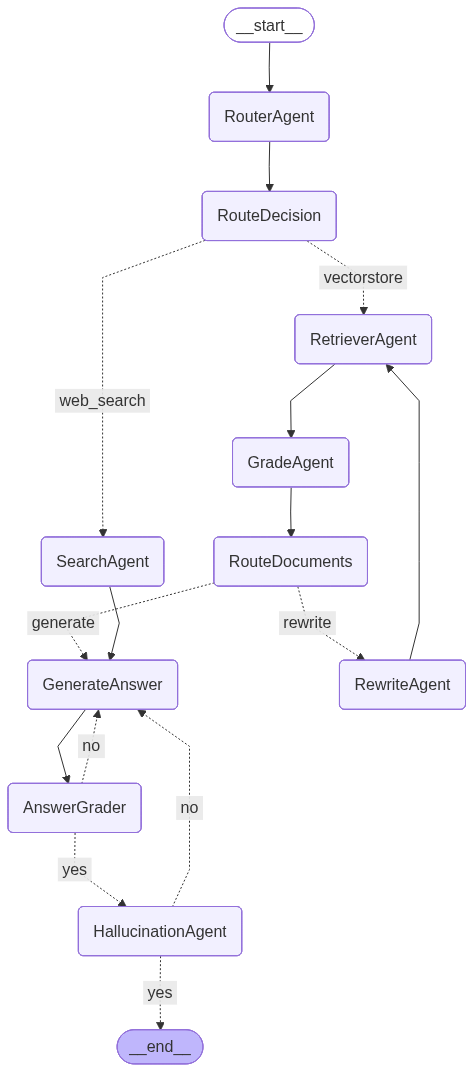

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
import pprint

inputs = {
    "query":
        "What are the types of agent memory?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Output from node 'RouterAgent':"
'---'
{'route': 'vectorstore'}
'\n---\n'
"Output from node 'RouteDecision':"
'---'
None
'\n---\n'
"Output from node 'RetrieverAgent':"
'---'
{ 'documents': 'Planning\n'
               '\n'
               'Subgoal and decomposition: The agent breaks down large tasks '
               'into smaller, manageable subgoals, enabling efficient handling '
               'of complex tasks.\n'
               'Reflection and refinement: The agent can do self-criticism and '
               'self-reflection over past actions, learn from mistakes and '
               'refine them for future steps, thereby improving the quality of '
               'final results.\n'
               '\n'
               '\n'
               'Memory\n'
               '\n'
               'Short-term memory: I would consider all the in-context '
               'learning (See Prompt Engineering) as utilizing short-term '
               'memory of the model to learn.\n'
               'Long-te

In [ ]:
output['HallucinationAgent']['answer']

'<think>\nOkay, the user is asking about the types of agent memory. Let me look through the provided context.\n\nIn the Memory section, it mentions Short-term memory and Long-term memory. Under Long-term, there\'s a breakdown into Explicit (declarative) and Implicit (procedural). Also, there\'s a mention of Sensory Memory in the human memory section. The Generative Agents part talks about Memory stream, Retrieval model, and Reflection mechanism. But the question is about types of agent memory, so I should focus on the categories listed. The context also includes Sensory, Short-term, and Long-term with subtypes. \n\nWait, the user\'s context includes both human memory types and agent memory systems. The answer should probably focus on the agent\'s memory as described, but the human memory types are also mentioned. Let me check again. The question is about agent memory, so maybe the answer should include the Short-term and Long-term as per the agent architecture. However, the human memor

In [ ]:
import pprint

inputs = {
    "query":
        "What is the zero shot learning in prompt engineering?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Output from node 'RouterAgent':"
'---'
{'route': 'vectorstore'}
'\n---\n'
"Output from node 'RouteDecision':"
'---'
None
'\n---\n'
"Output from node 'RetrieverAgent':"
'---'
{ 'documents': 'For example to produce education materials for kids,\n'
               '\n'
               'Describe what is quantum physics to a 6-year-old.\n'
               '\n'
               'And safe content,\n'
               '\n'
               '... in language that is safe for work.\n'
               'In-context instruction learning (Ye et al. 2023) combines '
               'few-shot learning with instruction prompting. It incorporates '
               'multiple demonstration examples across different tasks in the '
               'prompt, each demonstration consisting of instruction, task '
               'input and output. Note that their experiments were only on '
               'classification tasks and the instruction prompt contains all '
               'label options.\n'
               'Definition

In [ ]:
answer = app.invoke(input={"query": "Who won the Nobel Prize in Physics 2025?"})

In [ ]:
answer

{'query': 'Who won the Nobel Prize in Physics 2025?',
 'documents': '# Nobel Prize in physics awarded to 3 University of California faculty\n\nOctober 7, 2025Julia Busiek, UC Newsroom\n\nUC Santa Barbara emeritus professor John M. Martinis, UC Berkeley emeritus professor John Clarke and UC Santa Barbara professor Michel H. Devoret were awarded the 2025 Nobel Prize in physics for their contributions to macroscopic quantum tunneling.\n\nCredit: Niklas Elmehed © Nobel Prize Outreach [...] All three winners of today’s 2025 Nobel Prize in physics are faculty at the University of California. The Nobel Prize committeehonored John Clarke, Michel H. Devoret and John M. Martinis “for the discovery of macroscopic quantum mechanical tunneling and energy quantization in an electric circuit.” [...] More from UC Santa Barbara: UCSB physics professors John Martinis and Michel Devoret win 2025 Nobel Prize in physics\n\nMore from UC Berkeley: John Clarke, UC Berkeley emeritus professor, awarded 2025 Nob

In [ ]:
answer['answer']

'The Nobel Prize in Physics 2025 was awarded to John Clarke, Michel H. Devoret, and John M. Martinis. They were recognized for their contributions to macroscopic quantum tunneling, specifically "for the discovery of macroscopic quantum mechanical tunneling and energy quantization in an electric circuit." All three winners are faculty members at the University of California.'